In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import mpld3
import matplotlib.pyplot as plt
import base64
from io import BytesIO
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from statsmodels.graphics.mosaicplot import mosaic
from scipy.stats import skew
from scipy.stats import chi2_contingency
import seaborn as sns
from itertools import product

In [2]:
alz = pd.read_csv("/Users/kenogihara/Desktop/ALL_PROJECTS/alzheimers_project/alzheimers_disease_data.csv")
alz.head()

,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,...,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis,DoctorInCharge
0,4751,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,...,0,0,1.725883,0,0,0,1,0,0,XXXConfid
1,4752,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,...,0,0,2.592424,0,0,0,0,1,0,XXXConfid
2,4753,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,...,0,0,7.119548,0,1,0,1,0,0,XXXConfid
3,4754,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,...,0,1,6.481226,0,0,0,0,0,0,XXXConfid
4,4755,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,...,0,0,0.014691,0,0,1,1,0,0,XXXConfid


In [3]:
#Step 1: Introduction

"""
In this project, I develop a model that can predict whether someone has Alzheimer's Disease with 95% accuracy.
This dataset contains extensive information on 2,149 patients, including demographic details, lifestyle factors, 
medical history, clinical history, symptoms, and a diagnosis of Alzheimer's Disease. This dataset is taken from 
Kaggle.

A model that can predict diagnosis of Alzheimers is particularly helpful because it provides insight into the 
features and lifestyle factors that may have a signficant influence on the development of the disease. Moreover, 
early detection of the disease allows for timely intervention, which can slow the progression of the disease. Early
detection also has immense benefits for healthcare allocation because it allows doctors to provide the necessary 
care and support at the right time; thereby, preventing the need for future intensive treatment.
"""

alz.columns

Index(['PatientID', 'Age', 'Gender', 'Ethnicity', 'EducationLevel', 'BMI',
       'Smoking', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality',
       'SleepQuality', 'FamilyHistoryAlzheimers', 'CardiovascularDisease',
       'Diabetes', 'Depression', 'HeadInjury', 'Hypertension', 'SystolicBP',
       'DiastolicBP', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL',
       'CholesterolTriglycerides', 'MMSE', 'FunctionalAssessment',
       'MemoryComplaints', 'BehavioralProblems', 'ADL', 'Confusion',
       'Disorientation', 'PersonalityChanges', 'DifficultyCompletingTasks',
       'Forgetfulness', 'Diagnosis', 'DoctorInCharge'],
      dtype='object')

In [42]:
#Step 2: Data Cleaning and Exploratory Data Analysis

# alz = alz.drop(columns = "DoctorInCharge")
markdown_table = alz.head()[["PatientID", "Age", "Gender", "Ethnicity", "BMI", "Smoking", "PhysicalActivity", "Diagnosis"]].to_markdown(index = False)

#First univariate analysis that shows the distribution of patients according to their diagnosis.

mapping = {
    0: "Not Diagnosed",
    1: "Diagnosed"
}

alz["result"] = alz["Diagnosis"].map(mapping)

data = alz.groupby("result")["PatientID"].count() / alz.groupby("result")["PatientID"].count().sum()
data = data.reset_index()
data.columns = ["Diagnosis", "Proportion"]

fig = px.pie(data, names = "Diagnosis", values = "Proportion", title = "Distribution of Patients by Diagnosis",
            color_discrete_sequence = px.colors.qualitative.D3)
fig.update_layout(legend_title_text = "Diagnosis")

fig.update_traces(
    hoverinfo='label+percent', 
    textinfo='percent', 
    textfont_size=12,
    marker=dict(line=dict(color='#000000', width=2))
)

fig.show()

markdown_table = alz.head()[["PatientID", "Age", "Gender", "Ethnicity", "BMI", "Smoking", "PhysicalActivity", "Diagnosis"]].to_markdown(index = False)
# fig.write_html("/Users/kenogihara/Desktop/ALL_PROJECTS/alzheimers_project/assets/html.plot1.html", include_plotlyjs = "cdn")


In [5]:
#Second univariate analysis that shows the prevalence of Alzheimer's Disease Across Races

mapping = {
    0: "Caucasian",
    1: "African American", 
    2: "Asian",
    3: "Other"
}

data = alz.groupby("Ethnicity")["Diagnosis"].mean().reset_index().sort_values(by = "Diagnosis", ascending = False)
data["Ethnicity"] = data["Ethnicity"].map(mapping)
fig = px.bar(data, x = "Ethnicity", y = "Diagnosis", title = "Prevalence of Alzheimer's Disease Across Ethnicities", 
            color_discrete_sequence = px.colors.qualitative.D3)
fig.update_layout(yaxis_title = "Diagnosis Rate")

fig.show()
fig.write_html("/Users/kenogihara/Desktop/ALL_PROJECTS/alzheimers_project/assets/html.plot1 copy.html", include_plotlyjs = "cdn")

In [6]:
#Third univariate analysis that shows the prevalence of Alzheimer's Disease Across Education level

mapping = {
    0: "None",
    1: "High School", 
    2: "Bachelor's",
    3: "Higher"
}

data = alz.groupby("EducationLevel")["Diagnosis"].mean().reset_index()
data["EducationLevel"] = data["EducationLevel"].map(mapping)
fig = px.bar(data, x = "EducationLevel", y = "Diagnosis", title = "Prevalence of Alzheimer's Disease Across Education Level", 
            color_discrete_sequence = px.colors.qualitative.D3)
fig.update_layout(xaxis_title = "Education Level", yaxis_title = "Diagnosis Rate")
fig.show()
# fig.write_html("/Users/kenogihara/Desktop/ALL_PROJECTS/alzheimers_project/assets/html.plot1 copy2.html", include_plotlyjs = "cdn")

p_value: 0.0


'| MemoryComplaintsCat   |   Diagnosis |\n|:----------------------|------------:|\n| Memory Complaints     |    0.639821 |\n| No Memory Complaints  |    0.278496 |'

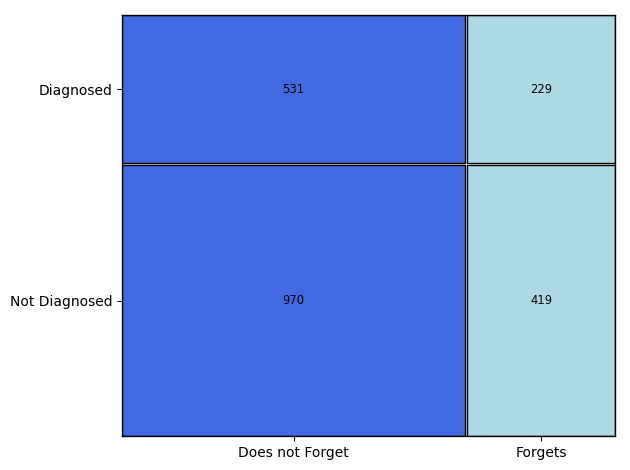

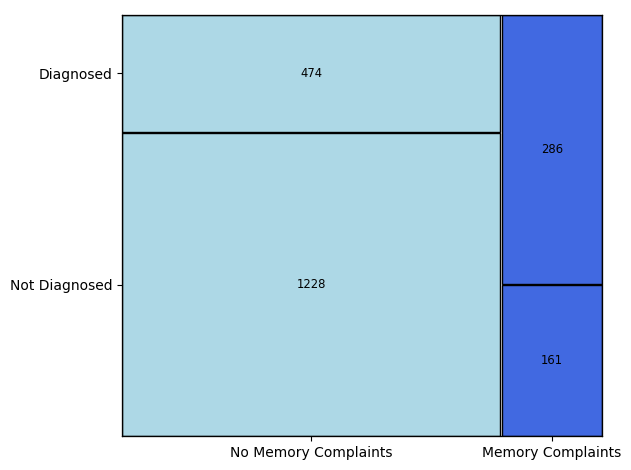

In [10]:
"""
In our dataset, the "Memory Complaints" variable referes to subjective experiences where individuals express
dissatisfaction or concern about their memory function. These concerns are self-reported. 

The "Forgetfulness" variable refers to the actual experience of forgetting information or events. It is an 
observable behavior where indiviudals fail to recall something that they had previously learned or experienced. 

I present my first bivariate analysis of these variables against diagnostic results.
"""

mapping = {
    0: "Does not Forget",
    1: "Forgets"
}

alz["ForgetfulnessCat"] = alz["Forgetfulness"].map(mapping)

crosstable = pd.crosstab(alz["result"], alz["ForgetfulnessCat"])
column_names = list(crosstable.columns)
alz_names = list(alz.columns)

props = {}

props[(column_names[1], str(crosstable.index[1]))] = {"facecolor" : "lightblue", "edgecolor" : "black"} #No memory complaints, not diagnosed
props[(column_names[1], str(crosstable.index[0]))] = {"facecolor" : "lightblue", "edgecolor" : "black"} #No memory complaints, diagnosed
props[(column_names[0], str(crosstable.index[1]))] = {"facecolor" : "royalblue", "edgecolor" : "black"} # Memory complaints, not diagnosed
props[(column_names[0], str(crosstable.index[0]))] = {"facecolor" : "royalblue", "edgecolor" : "black"} # Memory complaints, diagnosed


labelizer = lambda k: {
    (column_names[0], crosstable.index[1]): crosstable.loc["Not Diagnosed", "Does not Forget"],
    (column_names[1], crosstable.index[1]): crosstable.loc["Not Diagnosed", "Forgets"],
    (column_names[0], crosstable.index[0]): crosstable.loc["Diagnosed", "Does not Forget"],
    (column_names[1], crosstable.index[0]): crosstable.loc["Diagnosed", "Forgets"]
}[k]

fig = mosaic(alz, [alz_names[36], alz_names[35]], labelizer = labelizer, properties = props)
fig = fig[0]
fig.tight_layout()
tmpfile = BytesIO()
fig.savefig(tmpfile, format = "png")

encoded = base64.b64encode(tmpfile.getvalue()).decode('utf-8')

html = '<img src=\'data:image/png;base64,{}\'>'.format(encoded)

html_file_path = '/Users/kenogihara/Desktop/ALL_PROJECTS/alzheimers_project/assets/test.html'

# Write the HTML to a file
with open(html_file_path, 'w') as f:
    f.write(html)
    
    
    
    
    
    
    
    
    
    

mapping = {
    0: "No Memory Complaints",
    1: "Memory Complaints"
}

alz["MemoryComplaintsCat"] = alz["MemoryComplaints"].map(mapping)

crosstable = pd.crosstab(alz["result"], alz["MemoryComplaintsCat"])
column_names = list(crosstable.columns)
alz_names = list(alz.columns)

props = {}

props[(column_names[1], str(crosstable.index[1]))] = {"facecolor" : "lightblue", "edgecolor" : "black"} #No memory complaints, not diagnosed
props[(column_names[1], str(crosstable.index[0]))] = {"facecolor" : "lightblue", "edgecolor" : "black"} #No memory complaints, diagnosed
props[(column_names[0], str(crosstable.index[1]))] = {"facecolor" : "royalblue", "edgecolor" : "black"} # Memory complaints, not diagnosed
props[(column_names[0], str(crosstable.index[0]))] = {"facecolor" : "royalblue", "edgecolor" : "black"} # Memory complaints, diagnosed


labelizer = lambda k: {
    (column_names[0], crosstable.index[1]): crosstable.loc["Not Diagnosed", "Memory Complaints"],
    (column_names[1], crosstable.index[1]): crosstable.loc["Not Diagnosed", "No Memory Complaints"],
    (column_names[0], crosstable.index[0]): crosstable.loc["Diagnosed", "Memory Complaints"],
    (column_names[1], crosstable.index[0]): crosstable.loc["Diagnosed", "No Memory Complaints"]
}[k]

fig = mosaic(alz, [alz_names[37], alz_names[35]], labelizer = labelizer, properties = props)
fig = fig[0]
fig.tight_layout()
tmpfile = BytesIO()
fig.savefig(tmpfile, format = "png")

encoded = base64.b64encode(tmpfile.getvalue()).decode('utf-8')

html = '<img src=\'data:image/png;base64,{}\'>'.format(encoded)

html_file_path = '/Users/kenogihara/Desktop/ALL_PROJECTS/alzheimers_project/assets/test2.html'

# Write the HTML to a file
with open(html_file_path, 'w') as f:
    f.write(html)
    

table = pd.pivot_table(alz, index = "MemoryComplaintsCat", values = "Diagnosis", aggfunc = "mean")

"""
According to the first mosaic plot, we see that majority of patients are not considered forgetful. Regardless, in
both categories, the proportion of those who are diagnosed are approximately the same. This shows that
the presenece of forgetfulness is not a good indicator of Alzheimer's Disease.

According to the second mosaic plots, we see that the majority of patients do not report any memory complaints. Among
these patients, approximately 28% are diagnosed with Alzheimer's Disease. On the other hand, among those who report
memory complaints, 64% are diagnosed with Alzeimer's Disease. However, how do we know if this is actually true?
"""
#Step 3: Hypothesis Testing

"""
This leads into our next section, in which we perform hypothesis testing to see if the differences are legit or
due to random chance.

Null hypothesis: The differences are due to random chance. There isn't actually a relationship between diagnosis
and memory complaints.

Alternative hypothesis: The differences are not due to random chance. People who report memory complaints are more
likely to develop Alzheimer's Disease. 

"""

#Step 1: Compute the test statistic
#Step 2: Perform permutation testing by shuffling the memory column
#Step 3: Compute the p-value

# observed_ts = 
observed_ts = alz.groupby("MemoryComplaintsCat")["Diagnosis"].mean().loc["Memory Complaints"] - \
alz.groupby("MemoryComplaintsCat")["Diagnosis"].mean().loc["No Memory Complaints"]

n_repetitions = 1000
all_ts = []

for _ in range(n_repetitions):
    
    copy = alz.copy()
    copy["shuffled_memory_complaints"] = np.random.permutation(copy["MemoryComplaintsCat"])
    ts = copy.groupby("shuffled_memory_complaints")["Diagnosis"].mean().loc["Memory Complaints"] - \
alz.groupby("MemoryComplaintsCat")["Diagnosis"].mean().loc["No Memory Complaints"]

    all_ts.append(ts)
    
p_value = np.mean(np.array(all_ts) >= observed_ts)
print(f"p_value: {p_value}")

fig = px.histogram(pd.DataFrame(all_ts), x = 0, nbins = 50, histnorm = "probability", 
                title = f"Empirical Distribution of Differences")
fig.add_vline(x = observed_ts, line_color = "red", line_width = 2, opacity = 1)
fig.add_annotation(text=f'<span style="color:red">Observed TS = {round(observed_ts, 2)}</span>',
                    x=0.85 * observed_ts, showarrow=False, y=0.06)
fig.update_layout(xaxis_range = [-0.2, 0.4])
fig.update_layout(yaxis_range = [0, 0.1])
fig.show()
fig.write_html("/Users/kenogihara/Desktop/ALL_PROJECTS/alzheimers_project/assets/html_hypothesis_testing.html", include_plotlyjs = "cdn")

"""
Our p-value of 0.0 suggests that the alternative hypothesis is true. Therefore, we will reject the null hypothesis.
There is enough evidence to suggest that the differences are not due to random chance and that those who report
memory complaints are indeed more likely to be diagnosed with Alzheimer's Disease.

"""

table.to_markdown(index = True)

In [35]:
#Step 5: Framing a Prediction Problem

"""
I will predict whether a patient has Alzheimer's Disease using four different models: Logisitic Regression, 
DecisionTreeClassification, Random Forest Classifier, and Gradient Boost. I will use F1-score to calculate the 
models' accuracy since the data is severely imbalanced.

Before creating the models, we must find features that are highly correlated with the outcome. We will first
calculate the correlation of each variable based on their data type.
"""

categorical_columns = ["Gender", "Ethnicity", "EducationLevel", "Smoking", "FamilyHistoryAlzheimers", 
                      "CardiovascularDisease", "Diabetes", "Depression", "HeadInjury", "Hypertension",
                      "MemoryComplaints", "BehavioralProblems", "Confusion", "Disorientation", "PersonalityChanges",
                      "DifficultyCompletingTasks", "Forgetfulness"]

numerical_columns = []
for column in alz.columns:
    if column not in categorical_columns:
        numerical_columns.append(column)
        
columns_to_drop = ["PatientID", "DoctorInCharge", "result", "ForgetfulnessCat", "MemoryComplaintsCat"]
numerical_columns = [col for col in numerical_columns if col not in columns_to_drop]







#We use a correlation matrix to find highly correlated variables that are numerical
correlation_matrix_numerical = alz[numerical_columns].corr()
plt.figure(figsize = (12, 8))
sns.heatmap(correlation_matrix_numerical, annot = True, fmt = " .2f", cmap = "coolwarm")
plt.title("Correlation Matrix of Numerical Variables", fontsize = 13)
plt.tight_layout()

tmpfile = BytesIO()
plt.savefig(tmpfile, format = "png")
plt.close()

encoded = base64.b64encode(tmpfile.getvalue()).decode('utf-8')

html = f"""
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
</head>
<body>
    <img src="data:image/png;base64,{encoded}" alt="Correlation Matrix Heatmap">
</body>
</html>
"""



html_file_path = "/Users/kenogihara/Desktop/ALL_PROJECTS/alzheimers_project/assets/heatmap.html"
with open(html_file_path, 'w') as f:
    f.write(html)







"""
We see that MMSE, FunctionalAssessment, and ADL are the top 3 features that are correlated with Diagnosis.
Let's add a few more categorical features that we can potentially use in our model.
"""

#We use chi-squared test to find highly correlated variables that are categorical

def is_correlated(x, y):
    cross_table = pd.crosstab(index = alz[x], columns = alz[y])
    chi_sq_result = chi2_contingency(cross_table,)
    p, c = chi_sq_result[1], "correlated" if chi_sq_result[1] < 0.05 else "not correlated"
    return (x, p, c)

chi_sq_results = []
for column in categorical_columns:
    result = is_correlated(column, "Diagnosis")
    chi_sq_results.append(result)
    
chi_sq_results.sort(key=lambda x: x[1])
chi_sq_results
# #MemoryComplaints and BehavioralProblems are the top 2 most correlated variables with our binary outcome.

# #Selecting the top 10 best features for our model:
# best_features = [result[0] for result in chi_sq_results[:7]]
# best_features.append("MMSE")
# best_features.append("FunctionalAssessment")
# best_features.append("ADL")



[('MemoryComplaints', 1.5266050985264054e-45, 'correlated'),
 ('BehavioralProblems', 4.731446795211873e-25, 'correlated'),
 ('Ethnicity', 0.09780307184026778, 'not correlated'),
 ('Hypertension', 0.11808887156379336, 'not correlated'),
 ('FamilyHistoryAlzheimers', 0.14069795394928386, 'not correlated'),
 ('Diabetes', 0.16224495200138433, 'not correlated'),
 ('CardiovascularDisease', 0.1628367346921118, 'not correlated'),
 ('EducationLevel', 0.21650771973324673, 'not correlated'),
 ('Disorientation', 0.27978377696750084, 'not correlated'),
 ('Gender', 0.35381831348465786, 'not correlated'),
 ('HeadInjury', 0.3603226855585838, 'not correlated'),
 ('PersonalityChanges', 0.37175710638032144, 'not correlated'),
 ('Confusion', 0.4045413830124688, 'not correlated'),
 ('DifficultyCompletingTasks', 0.7198556855473033, 'not correlated'),
 ('Depression', 0.8283335436917469, 'not correlated'),
 ('Smoking', 0.860493227376371, 'not correlated'),
 ('Forgetfulness', 1.0, 'not correlated')]

In [40]:
#Step 6: Building the Model

X_train, X_test, y_train, y_test = train_test_split(alz[best_features], alz["Diagnosis"], random_state = 42)

stdscaler = StandardScaler()
X_train = stdscaler.fit_transform(X_train)
X_test = stdscaler.fit_transform(X_test)

def train_and_evaluate(classifier, X_train, X_test, y_train, y_test):
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    classifier_test_score = classifier.score(X_test, y_test)
    classifier_precision_score = metrics.precision_score(y_test, y_pred)
    classifier_recall_score = metrics.recall_score(y_test, y_pred)
    classifier_f1_score = metrics.f1_score(y_test, y_pred)
    
    #Plot ROC curve
    plt.figure(figsize=(8, 6))
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='royalblue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) for {classifier}')
    plt.legend(loc="lower right")
    
    plt.tight_layout()
    tmpfile = BytesIO()
    plt.savefig(tmpfile, format = "png")
    plt.close()

    encoded = base64.b64encode(tmpfile.getvalue()).decode('utf-8')

    html = f"""
    <!DOCTYPE html>
    <html lang="en">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
    </head>
    <body>
        <img src="data:image/png;base64,{encoded}" alt="ROC Curve">
    </body>
    </html>
    """



    html_file_path = f"/Users/kenogihara/Desktop/ALL_PROJECTS/alzheimers_project/assets/roc_curve_{classifier}.html"
    with open(html_file_path, 'w') as f:
        f.write(html)
    
    
    return pd.DataFrame({f"{classifier}": [classifier_test_score, classifier_precision_score, classifier_recall_score, 
                         classifier_f1_score]})

logistic_reg = train_and_evaluate(LogisticRegression(random_state = 42), X_train, X_test, y_train, y_test)
dt = train_and_evaluate(DecisionTreeClassifier(random_state = 42), X_train, X_test, y_train, y_test)
rf = train_and_evaluate(RandomForestClassifier(random_state = 42), X_train, X_test, y_train, y_test)
gb = train_and_evaluate(GradientBoostingClassifier(random_state = 42), X_train, X_test, y_train, y_test)

result = pd.concat([logistic_reg, dt, rf, gb], axis = 1)
result.index = ["Test score", "Precision score", "Recall score", "F1 score"]
result.columns = ["Logistic Regression", "Decision Tree Classifier", "Random Forest Classifier", 
                 "Gradient Boosting Classifier"]


# result.to_markdown(index = True)

"""
Based on our results, the GradientBoostingClassifier is the most promising model. It has the highest ROC AUC at 0.94. This means that the model has a 94% chance of correctly distinguishing between patients with and without Alzheimer's Disease across various threshold levels. The ROC AUC score indicates strong overall discriminative power.
Further analysis shows that the true positive rate, also known as, recall score is 92%. This means that the model incorrectly identifies a person as negative 8% of the time. Optimizing a model's recall is especially important in the medicine since
false negatives are worse than false positives. 
"""


"\nBased on our results, the GradientBoostingClassifier is the most promising model. It has the highest ROC AUC at 0.94. This means that the model has a 94% chance of correctly distinguishing between patients with and without Alzheimer's Disease across various threshold levels. The ROC AUC score indicates strong overall discriminative power.\nFurther analysis shows that the true positive rate, also known as, recall score is 92%. This means that the model incorrectly identifies a person as negative 8% of the time. Optimizing a model's recall is especially important in the medicine since\nfalse negatives are worse than false positives. \n"